# ARIMA Modeling

> Authors: Joseph Nelson, Justin Pounders, Matt Brems

### Learning Objectives
By the end of this lesson, students should be able to:
- Generate and interpret ACF and PACF plots.
- Create a proper train/test split on time series data.
- Define stationarity.
- Conduct and interpret an augmented Dickey-Fuller test for stationarity.
- Construct integrated autoregressive moving average (ARIMA) models.
- Describe when autoregressive models and moving average models are appropriate.
- Identify the optimal values of parameters $p$, $d$, and $q$ through GridSearch.
- Identify when seasonality exists in time series data.
- Fit and tune a SARIMAX model.
- Fit a multivariate time series model.

In [1]:
# Run this to ensure that statsmodels is version 0.9.0 and scipy is version 1.2.0.
# !pip install scipy statsmodels --upgrade

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

In [3]:
# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Bus Ridership Data
> We're going to work with bus ridership data from the 1970s and 1980s. We have:
- `date`: the start date for that month's ridership.
- `bus_ridership`: how many people rode the bus each month (in thousands).

### Portland Precipitation Data
> We also have [precipitation data](https://w2.weather.gov/climate/local_data.php?wfo=PQR) measuring the amount of precipitation that fell at Portland's airport during the same dates as the bus ridership data was collected (1973-1982).
- `YR`: the year the data was measured.
- `MO`: the month the data was measured.
- `total_precip`: the amount of precipitation (in inches).

In [4]:
# Read in data.
bus = pd.read_csv('../datasets/bus.csv')

# Check out first five rows.
bus.head()

,date,bus_ridership
0,1973-01-01,648
1,1973-02-01,646
2,1973-03-02,639
3,1973-04-02,654
4,1973-05-02,630


In [5]:
# Read in data.
precip = pd.read_csv('../datasets/precipitation.csv')

# Check out first five rows.
precip.head()

,YR,MO,total_precip
0,1973,1,3.69
1,1973,2,1.94
2,1973,3,2.45
3,1973,4,1.33
4,1973,5,1.43


In [6]:
portland = pd.merge(left=bus,
                    right=precip,
                    left_on=bus.index,
                    right_on=precip.index)

In [7]:
portland.head()

,key_0,date,bus_ridership,YR,MO,total_precip
0,0,1973-01-01,648,1973,1,3.69
1,1,1973-02-01,646,1973,2,1.94
2,2,1973-03-02,639,1973,3,2.45
3,3,1973-04-02,654,1973,4,1.33
4,4,1973-05-02,630,1973,5,1.43


In [8]:
portland.drop(columns=['key_0', 'YR', 'MO'], inplace=True)

In [9]:
portland.head()

,date,bus_ridership,total_precip
0,1973-01-01,648,3.69
1,1973-02-01,646,1.94
2,1973-03-02,639,2.45
3,1973-04-02,654,1.33
4,1973-05-02,630,1.43


### Create a Date Index for the Data
We are going to change our index to match the date.

In [10]:
# Use the "date" column to set the index.
portland.set_index('date', inplace=True)

In [11]:
# Confirm that we did this correctly.
portland.head()

,bus_ridership,total_precip
date,,
1973-01-01,648,3.69
1973-02-01,646,1.94
1973-03-02,639,2.45
1973-04-02,654,1.33
1973-05-02,630,1.43


In [12]:
# Check out the index only.
portland.index

Index(['1973-01-01', '1973-02-01', '1973-03-02', '1973-04-02', '1973-05-02',
       '1973-06-02', '1973-07-02', '1973-08-02', '1973-09-02', '1973-10-02',
       ...
       '1981-09-02', '1981-10-02', '1981-11-02', '1981-12-02', '1982-01-02',
       '1982-02-02', '1982-03-02', '1982-04-02', '1982-05-02', '1982-06-02'],
      dtype='object', name='date', length=114)

Rather than have the index show the start date for the month, let it be the end date so it reflects when the value was recorded.

In [13]:
# Edit the index.
portland.index = pd.date_range('1/1/1973', # start date is January 1, 1973
                               periods=len(portland.index), # we want one period per entry
                               freq='M') # frequency in months

# Confirm we edited the index properly.
portland.index

DatetimeIndex(['1973-01-31', '1973-02-28', '1973-03-31', '1973-04-30',
               '1973-05-31', '1973-06-30', '1973-07-31', '1973-08-31',
               '1973-09-30', '1973-10-31',
               ...
               '1981-09-30', '1981-10-31', '1981-11-30', '1981-12-31',
               '1982-01-31', '1982-02-28', '1982-03-31', '1982-04-30',
               '1982-05-31', '1982-06-30'],
              dtype='datetime64[ns]', length=114, freq='M')

Let's plot this raw data.

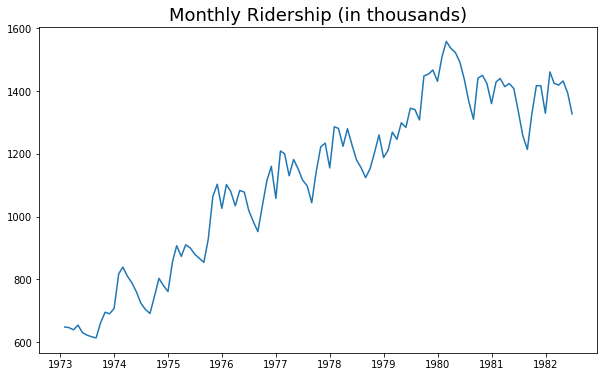

In [14]:
# Set figure size.
plt.figure(figsize=(10,6))

# Generate line plot of bus_ridership.
plt.plot(portland['bus_ridership'])
plt.title(label='Monthly Ridership (in thousands)', fontsize=18);

<details><summary>Check: How would you describe this data?</summary>
    
- The data are correlated with one another.
- The mean (straight-line trend) is increasing.
- There appears to be some seasonality each year; this is especially apparent in the 1976-1979 window.
</details>

## Train/Test Split

Our goal, as with all train/test splits, is to:
- avoid overfitting in our model, and
- to get an unbiased estimate of model performance on new, "unseen" data.

When fitting a time series model, we shouldn't do a random train-test split like we do with non-correlated data.

Since our goal with time series analysis is almost always to forecast values forward in time, the idea with a time series train/test split is to train on earlier data and test/evaluate on later data.

Most commonly, we'll set our:
- training set to be the "first" 67% - 80% of our data timewise.
- test set be the "last" 20% - 33% timewise.

Let's split our dataframe by taking the first 80% of rows for training and the rest for testing.

In [15]:
# What index gives us our 80th percentile of rows?
portland.shape[0] * (4 / 5)

91.2

In [16]:
# Set training data to be first 80% of rows.
train = portland.iloc[0:91]

# Check shape to confirm we did this properly.
train.shape

(91, 2)

In [17]:
# Set testing data to be last 20% of rows.
test = portland.iloc[91:]

# Check shape to confirm we did this properly.
test.shape

(23, 2)

## ARIMA Model

An [ARIMA model](http://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html#statsmodels.tsa.arima_model.ARIMA) is a very useful model that forms the basis for most of time series modeling.

ARIMA stands for:
- Integrated
- AutoRegressive
- Moving Average models.

*(That ordering isn't a typo)*.

There are three pieces to ARIMA modeling.
1. "Differencing" step.
2. Autoregressive piece.
3. Moving average piece.

We'll cover each of these in order.

### Differencing

The purpose of the differencing step is to satisfy one assumption that is crucial to fitting an ARIMA model: **stationarity**.

#### Stationarity

Stationarity, formally, means that our time series:
- has a constant mean over time.
- has an autocorrelation that only depends on lag $k$, not on time $t$. (That is, $Corr(Y_t, Y_{t-k})$ should only depend on how far apart the observations are in time.)

Informally, stationarity means that there aren't systematic changes in our time series over time.
- A sine curve is a good example of a stationary time series.

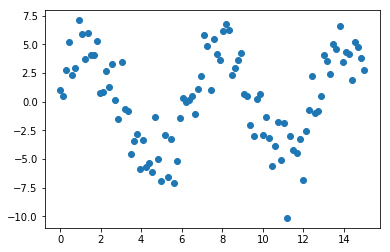

In [18]:
np.random.seed(42)

t = np.linspace(0, 15, 100)
y = 5 * np.sin(t) + np.random.normal(0, 2, 100)

plt.scatter(t, y);

The problem is, many time series **aren't stationary**.
- The amount that stock prices vary on a day-to-day basis aren't going to be the same.
- Crop prices may increase or decrease over time; assuming a constant mean here doesn't make sense.

So, what do we do?
- We'll check to see if our data are stationary.
- If our data aren't stationary, then that's where we difference our time series.

#### Checking for Stationarity: the Augmented Dickey-Fuller Test

The [augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) is a hypothesis test that tests for stationarity. We assume that our data are not stationary. With enough evidence, we may accept that our data are stationary.

Specifically, the test is as follows:

$$
\begin{eqnarray}
&H_0:& \text{not stationary} \\
&H_A:& \text{stationary}
\end{eqnarray}
$$

<details><summary>Thus, would a small $p$-value or a large $p$-value give us evidence that our time series is stationary?</summary>

- A small $p$-value would give us evidence to reject the null hypothesis, meaning we accept that our time series is stationary.
</details>


### Integrated Autoregressive Moving Average (ARIMA) Models

Often, our time series data will see both long-term trends **and** sudden fluctuations. Thus, we want to combine AR and MA models together.

<details><summary>Check: What are some examples where we might see both long-term trends and sudden fluctuations in our time series data? </summary>

- Stock price data. Stocks increase and decrease over time, but news or other stock changes may have sudden effects on prices.
- Gas or oil prices. Similar logic as stock prices.
- Public transportation ridership. While public transportation may see slow changes over time, marketing campaigns, changes in price, or accidents may have a sudden, unforeseen shock on ridership.
</details>

An [ARIMA model](http://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html#statsmodels.tsa.arima_model.ARIMA) is a very useful and very general model. We are literally just adding together our AR(p) and MA(q) models, with one additional change.

$$
\begin{eqnarray*}
Y_t - Y_{t-d} &=& AR(p) + MA(q) \\
&=& \mu + \sum_{k=1}^p \beta_kY_{t-k} + \sum_{i=1}^q w_i\varepsilon_{t-i} + \varepsilon_t
\end{eqnarray*}
$$

Note that we are not predicting $Y_t$, but instead $Y_t - Y_{t-d}$. We difference our time series. This is because, in order for AR, MA, and ARIMA models to work, we need to meet one assumption: **stationarity**.



### Augmented Dickey-Fuller Test


In [19]:
from statsmodels.tsa.stattools import adfuller

adfuller(train['bus_ridership'])

(-0.5909480353423043,
 0.8730143095579228,
 12,
 78,
 {'1%': -3.517113604831504,
  '5%': -2.8993754262546574,
  '10%': -2.5869547797501644},
 812.0468124533252)

In [20]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [21]:
interpret_dftest(adfuller(train['bus_ridership']))

Test Statistic   -0.590948
p-value           0.873014
dtype: float64

<details><summary>How would we interpret this $p$-value? </summary>
    
- Remember that we compare our $p$-value to $\alpha$, which is usually set at 0.10, 0.05, or 0.01. Because $p = 0.87$, it is larger than any $\alpha$ we'd reasonably pick. Thus, we cannot accept that our series `bus_ridership` is stationary.
</details>

##### In order to achieve stationarity, we need to difference!

Differencing our time series means that instead of modeling our time series $Y_t$ directly, we'll model some difference:

$$
\begin{eqnarray*}
\Delta_t &=& Y_t - Y_{t-d}
\end{eqnarray*}
$$

Maybe the time series $Y_1, Y_2, \ldots$ is not stationary... but the difference between time period $t-d$ and time period $t$ might be!

Why do we difference? 
- Differencing allows us to get a stationary time series out of a non-stationary time series.
- This means that we'll be able to fit an ARIMA model to the **differenced** data!

We'll start with a difference of $d = 1$ and iterate upward until we find a value of $d$ that makes our time series stationary.

In [22]:
# Write a for loop to find the lowest difference value d.

# Iterate through all possible differences.
for d in range(1, len(train['bus_ridership'])):
    
    # Print out a counter and the corresponding p-value.
    print(f'Checking difference of {d}.')
    print(f'p-value = {interpret_dftest(adfuller(train["bus_ridership"].diff(d).dropna()))["p-value"]}.')
          
    # If our data, differenced by d time periods, are stationary, print that out!
    if interpret_dftest(adfuller(train['bus_ridership'].diff(d).dropna()))['p-value'] < 0.05:
        print(f'Differencing our time series by d={d} yields a stationary time series!')
        break
    
    print()

Checking difference of 1.
p-value = 0.19819753102854604.

Checking difference of 2.
p-value = 0.11481778228986322.

Checking difference of 3.
p-value = 0.1976459747305867.

Checking difference of 4.
p-value = 0.023887227697658678.
Differencing our time series by d=4 yields a stationary time series!


From this process, we would conclude that we should difference our time series by a lag of $d=4$.
- Rather than modeling $Y_t$ directly, we'll model $\Delta_t = Y_t - Y_{t-4}$.
- If we generate autocorrelation and partial autocorrelation plots moving forward, then we should generate plots of the **differenced** time series, not the original time series!

There are three pieces to ARIMA modeling.
1. "Differencing" step.
2. Autoregressive piece.
3. Moving average piece.

### Autoregressive Piece

The next piece to ARIMA modeling that we'll cover is the **autoregressive** piece, commonly abbreviated `AR`.

<details><summary>Check: Without us covering it, what do you think the autoregressive piece might do?</summary>

- An autoregressive model is where we regress a variable on itself by regressing newer values on older values. For example, $Y_t = \beta_0 + \beta_1Y_{t-1} + \beta_2Y_{t-2}$.
- A helpful hint to remembering autoregressive models is to think about the prefix "auto:"
    - Autocorrelation is the correlation of one variable with itself. 
    - An autobiography is a book written by a person, about that same person. 
    - An autotransplant is a surgical procedure in which an organ is transplanted from a person to that same person.
</details>

The autoregressive piece to the ARIMA model is responsible for **modeling the long-term trends** in our time series, like:
- the changes in crop yield over time in response to climate change, or 
- the relatively steady increase of employees within an organization over time. 

The autoregressive piece **doesn't handle sudden, random shocks well**, like:
- a wildfire or overly rainy season dramatically impacting crop yield, or
- a massive acquisition/layoff that leads to a sudden jump/drop in the number of employees in an organization.

The autoregressive piece of our ARIMA model will learn regression coefficients on the features that are the previous $p$ values. 
- An $AR(1)$ piece includes one prior value: $\beta_0 + \beta_1Y_{t-1}$
- An $AR(2)$ piece includes two prior values: $\beta_0 + \beta_1Y_{t-1} + \beta_2Y_{t-2}$
- An $AR(p)$ piece includes $p$ prior values: $\beta_0 + \sum_{k=1}^p \beta_kY_{t-k}$

<details><summary>Check: How do you think we might decide on a value of $p$?</summary>

- We could use our autocorrelation plot to see for what values of $k$ there is a significant correlation between $Y_t$ and $Y_{t-k}$.
</details>

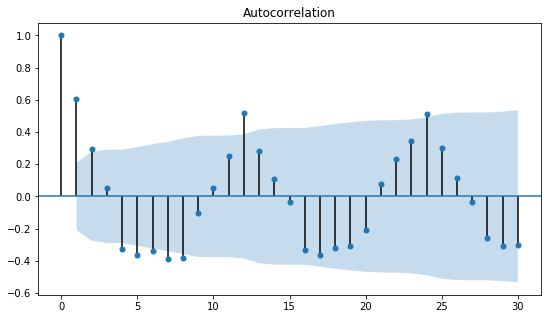

In [23]:
# Set figure/axes.
fig, ax = plt.subplots(figsize=(9,5))

# Generate plot.
plot_acf(train["bus_ridership"].diff(4).dropna(), lags=30, ax=ax);

### Visual:
| Index | $Y_t$ | $Y_{t-1}$ | $Y_{t-2}$ | $Y_{t-3}$ |
|-------|-------|-----------|-----------|-----------|
| 1     | $y_1$ | NaN       | NaN       | NaN       |
| 2     | $y_2$ | $y_1$     | NaN       | NaN       |
| 3     | $y_3$ | $y_2$     | $y_1$     | NaN       |
| 4     | $y_4$ | $y_3$     | $y_2$     | $y_1$     |

- The left-most value of the autocorrelation plot is $Corr(Y_t, Y_t)$. This should always be 1! (The height of the blue dot will always be 1.)
- The next value (moving one step to the right) of the autocorrelation plot visualizes $Corr(Y_t, Y_{t-1})$. The height of the blue dot here is about 0.95.
- The next value of the autocorrelation plot visualizes $Corr(Y_t, Y_{t-2})$.
- And so on...

<details><summary>Based on the plot above, for what lags $k$ is $Y_t$ significantly correlated with $Y_{t-k}$?</summary>
    
#### This is the main point of interpreting an autocorrelation plot.
- Remember that the autocorrelation plot above shows that observations are highly correlated with one another. 
- For example, this plot shows that observations that are one time lag apart have a correlation around 60%. Observations that are two time lags apart have a correlation around 30%. (And so on...)
- The blue band indicates the 95% confidence interval for these correlations.
    - Observations inside the blue band mean that there is no significant correlations between $Y_t$ and $Y_{t-k}$ for lag $k$.
    - Observations outside the blue band mean that there **is** a significant correlation between $Y_t$ and $Y_{t-k}$ for lag $k$.

#### Thus, there is a statistically significant correlation between $Y_t$ and $Y_{t-k}$ for $k = 1, 2, 4, 5, 6, 7, 8, 12, and 24$.
</details>

<details><summary>Check: What might be a downside of relying solely on this plot?</summary>

- If $Y_t$ is correlated with $Y_{t-1}$ and $Y_{t-2}$, then $Y_{t-1}$ and $Y_{t-2}$ are also likely correlated. We should have some way to account for how correlated all these are. **Enter the partial autocorrelation plot!**
</details>

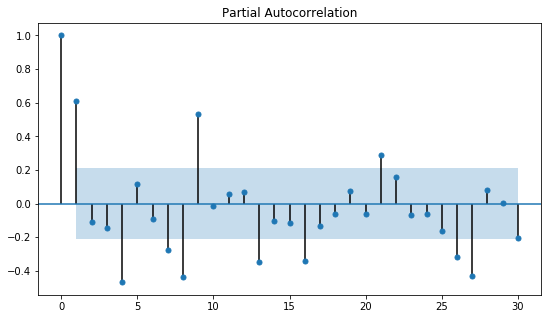

In [24]:
# Set figure/axes.
fig, ax = plt.subplots(figsize=(9,5))

# Generate plot.
plot_pacf(train["bus_ridership"].diff(4).dropna(), lags=30, ax=ax);

<details><summary>How would you interpret the partial autocorrelation plot here?</summary>

### Interpret the partial autocorrelation plot.
1. The partial autocorrelation plot above shows that observations are highly correlated with one another. 
2. **However, the partial autocorrelation plot checks for the correlation between observations, conditioning on all lower-lag autocorrelations.** (That is, the partial autocorrelation between $Y_t$ and $Y_{t-2}$ is the correlation between $Y_t$ and $Y_{t-2}$ that has already taken into account the autocorrelation between $Y_t$ and $Y_{t-1}$.)
3. The blue band indicates the 95% confidence interval for these correlations.
    - Observations inside the blue band mean that there is no significant correlations between $Y_t$ and $Y_{t-k}$ for lag $k$, **accounting for all lower-order lags**.
    - Observations outside the blue band mean that there **is** a significant correlation between $Y_t$ and $Y_{t-k}$ for lag $k$, **accounting for all lower-order lags**.
</details>

#### Determining a Value of $p$ based on the ACF and PACF.

If the PACF (partial autocorrelation function) has a sharp cut-off and the lag-1 ACF (autocorrelation function) value is positive, choose $p$ to be the lag in the PACF before the cut-off.
- Note: $p=1$ is the most common.

If the PACF does not have a sharp cut-off or the lag-1 ACF value is not positive, then let $p=0$.

<details><summary>Based on the ACF and PACF, what value of $p$ would you select?</summary>

- The PACF has a sharp cut-off between lag 1 and lag 2.
- The first lag in the ACF is positive.
- Thus, we should set $p=1$.
</details>

### Fit an ARIMA model.

There are three pieces to ARIMA modeling.
1. "Differencing" step.
2. Autoregressive piece.
3. Moving average piece.

We haven't yet learned about the moving average piece, but let's fit an ARIMA model now, then come back to talk about the moving average piece.

In [25]:
# Import ARIMA model.
from statsmodels.tsa.arima_model import ARIMA

In [26]:
# Instantiate model.

# Remember that, in statsmodels, we pass our data 
# in when we instantiate the model!

model = ARIMA(endog = train['bus_ridership'].diff(4).dropna(), # endog = Y variable
              order = (1,0,0)) # (p, d, q) <-- talk about q later!

# Note that we manually difference our data.
# In the present version of statsmodels, only
# certain values of d are supported.

In [27]:
# Fit model.
arima_1_4_0 = model.fit()

In [28]:
# Generate predictions.
preds = arima_1_4_0.predict()

In [29]:
preds.head()

1973-05-31    32.036475
1973-06-30     0.193660
1973-07-31    -3.624693
1973-08-31    -2.351909
1973-09-30   -14.443358
Freq: M, dtype: float64

<details><summary>What do these predicted values represent?</summary>

- These predicted values represent $\hat{\Delta}_t$, which is the 4-lagged
- The first observation represents how much the bus ridership will change between January 1973 and May 1973.
- The second observation represents how much the bus ridership will change between February 1973 and June 1973.
- And so on.
</details>

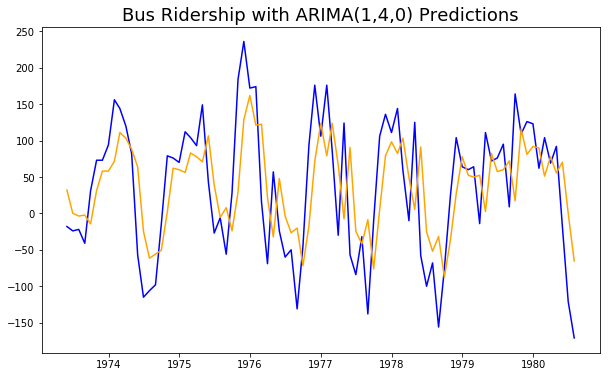

In [30]:
# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train['bus_ridership'].diff(4).dropna(), color = 'blue')
plt.plot(preds, color = 'orange')
plt.title(label = 'Bus Ridership with ARIMA(1,4,0) Predictions', fontsize=18)
plt.show();

In [31]:
# Evaluate these predictions using MSE.

from sklearn.metrics import mean_squared_error
mean_squared_error(train['bus_ridership'].diff(4).dropna(), preds)

5159.349572105408

We would call the above model an $ARIMA(1, 4, 0)$ model.

In general, ARIMA is parameterized as $ARIMA(p, d, q)$, where: 
- $d$ is the order of differencing we found using the Augmented Dickey-Fuller test.
- $p$ is the number of autoregressive terms in our model.
- and $q$ is coming up next!

There are three pieces to ARIMA modeling.
1. "Differencing" step.
2. Autoregressive piece.
3. Moving average piece.

### Moving Average Piece

The final piece to ARIMA modeling that we'll cover is the **moving average** piece, commonly abbreviated `MA`.

In the moving average piece, we take **previous error terms** as inputs. They predict the next value based on deviations from previous predictions.
- A $MA(1)$ piece regresses $Y_t$ on one prior error: $\mu + w_1\varepsilon_{t-1} + \varepsilon_t$
- A $MA(2)$ piece regresses $Y_t$ on two prior errors: $\mu + w_1\varepsilon_{t-1} + w_2\varepsilon_{t-2} + \varepsilon_t$
- A $MA(3)$ piece regresses $Y_t$ on three prior errors: $\mu + w_1\varepsilon_{t-1} + w_2\varepsilon_{t-2} + w_3\varepsilon_{t-3} + \varepsilon_t$

We denote this piece as $MA(q)$, where $q$ indicates the number of previous errors to incorporate.

The moving average piece **does handle sudden, random shocks well**, (unlike the AR piece) like:
- a wildfire or overly rainy season dramatically impacting crop yield, or
- a massive acquisition/layoff that leads to a sudden jump/drop in the number of employees in an organization.

<details><summary>Technical Bonus Note:</summary>

- Because the error terms ($\varepsilon$) are unobserved, we rely on sophisticated algorithms to estimate the coefficients $w_i$ when fitting this model. [Check out a paper on the topic here.](https://www.it.uu.se/research/publications/reports/2006-022/2006-022-nc.pdf)
</details>

#### Determining a Value of $q$ based on the ACF and PACF.

If the PACF (partial autocorrelation function) has a sharp cut-off and the lag-1 ACF (autocorrelation function) value is negative, choose $q$ to be the lag in the ACF before the cut-off.
- Note: $p$ is determined by the lag in the PACF; $q$ is determined by the lag in the ACF.

If the PACF does not have a sharp cut-off or the lag-1 ACF value is not negative, then let $q=0$.

<details><summary>Based on the ACF and PACF, what value of $q$ would you select?</summary>

- The PACF has a sharp cut-off between lag 1 and lag 2.
- The first lag in the ACF is positive.
- Thus, we should set $q=0$.
</details>

**Recap:** The AR piece is appropriate when modeling long-term trends in our process. The MA piece is appropriate when modeling sudden fluctuations in our process.

### Pulling the ARIMA Model Together

There are three pieces to ARIMA modeling.
1. "Differencing" step.
2. Autoregressive piece.
3. Moving average piece.

Often, our time series data will see both long-term trends **and** sudden fluctuations. Thus, we want to combine AR and MA pieces together.

<details><summary>Check: What are some examples where we might see both long-term trends and sudden fluctuations in our time series data? </summary>

- Stock price data. Stocks increase and decrease over time, but news or other stock changes may have sudden effects on prices.
- Gas or oil prices. Similar logic as stock prices.
- Public transportation ridership. While public transportation may see slow changes over time, marketing campaigns, changes in price, or accidents may have a sudden, unforeseen shock on ridership.
</details>

- An ARIMA(p, d, q) model is specified by:
    - how many lags $p$ we regress $Y_t$ on.
    - how many errors $q$ we regress $Y_t$ on.
    - and how many differences $d$ we want to calculate in order to achieve stationarity.

An $ARIMA(p,d,q)$ model is specified as follows:
$$
\begin{eqnarray*}
ARIMA(p,d,q) \Rightarrow Y_t - Y_{t-d} &=& AR(p) + MA(q) \\
Y_t - Y_{t-d} &=& \mu + \sum_{k=1}^p \beta_kY_{t-k} + \sum_{i=1}^q w_i\varepsilon_{t-i} + \varepsilon_t
\end{eqnarray*}
$$

Depending on our values of $p$, $d$, and $q$, we might refer to these models by slightly different names.

- If $d=0$ and $q=0$, an AR(p) model is specified by how many lags $p$ we regress $Y_t$ on.
- If $d=0$ and $p=0$, an MA(q) model is specified by how many errors $q$ we regress $Y_t$ on.
- If $d=0$, an ARMA(p, q) model is specified by how many lags $p$ and how many errors $q$ we regress $Y_t$ on.

| p | d | q |          Model         |
|:-:|:-:|:-:|:----------------------:|
| 1 | 0 | 0 |  ARIMA(1,0,0) = AR(1)  |
| 0 | 0 | 1 |  ARIMA(0,0,1) = MA(1)  |
| 1 | 0 | 1 | ARIMA(1,0,1) = ARMA(1) |
| 1 | 1 | 1 |      ARIMA(1,1,1)      |
| 1 | 1 | 0 |      ARIMA(1,1,0)      |
| 0 | 1 | 1 |      ARIMA(0,1,1)      |


How do we find the right values of $p$, $d$, $q$?
- Manually looking through plots and the Augmented Dickey-Fuller test is the best way to go (like we did above).
- "GridSearch" to find the right difference.

In [32]:
for p in range(4):
    for d in range(4):
        for q in range(4):
            arima = ARIMA(endog = train['bus_ridership'].astype('float32'), # Y variable
                          order = (p, d, q)) # (p, d, q)
            model = arima.fit()
            preds = model.predict()
            print(f'The MSE for (p = {p}, d = {d}, q = {q}) is {mean_squared_error(train["bus_ridership"], preds)}.')

The MSE for (p = 0, d = 0, q = 0) is 67941.90602535535.
The MSE for (p = 0, d = 0, q = 1) is 23035.185997187582.


ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

Remember, finding coefficients for an MA (or ARMA or ARIMA) model is difficult.

For example, consider an $MA(2)$ model.
$$MA(2) \Rightarrow Y_t = \mu + w_1\varepsilon_{t-1} + w_2\varepsilon_{t-2} + \varepsilon_t$$

The model requires us to regress on errors, but we don't actually observe these errors. (The algorithm for fitting this is complicated and is beyond the scope of this lesson. [Check more out here](https://www.it.uu.se/research/publications/reports/2006-022/2006-022-nc.pdf).)

There are a few ways to handle this:
- Add a seasonal component to our model.
- Specify a different model.
- "Hack" our answer by adding `try` and `except` statements to our for loops.

<details><summary>What is the purpose of try and except statements?</summary>

- If our code encounters an error, then it will automatically stop. Sometimes this is good (so we can debug) but sometimes this isn't desirable!
- `try` and `except` statements allow us to "try" to do something and, if there's an error, we can just `pass` it so that our code doesn't stop running.
- This isn't always a good thing... errors are usually telling us that something is wrong. But we're going to hack our answer here so that we can check all values of $p$, $d$, and $q$ and just not run the model if some values of $p$, $d$, and $q$ are invalid.
</details>

In [34]:
for p in range(4):
    for d in range(4):
        for q in range(4):
            try:
                arima = ARIMA(endog = train['bus_ridership'].astype('float32'), # Y variable
                              order = (p, d, q)) # (p, d, q)
                model = arima.fit()
                preds = model.predict()
                print(f'The MSE for (p = {p}, d = {d}, q = {q}) is {mean_squared_error(train["bus_ridership"], preds)}.')
            
            except:
                pass

The MSE for (p = 0, d = 0, q = 0) is 67941.90602535535.
The MSE for (p = 0, d = 0, q = 1) is 23035.185997187582.
The MSE for (p = 1, d = 0, q = 0) is 4496.239977648672.
The MSE for (p = 1, d = 0, q = 1) is 4487.494791098906.
The MSE for (p = 1, d = 0, q = 2) is 4423.525096089474.
The MSE for (p = 1, d = 0, q = 3) is 4287.360406849972.
The MSE for (p = 2, d = 0, q = 0) is 4490.219499034728.
The MSE for (p = 2, d = 0, q = 1) is 4443.725682017212.
The MSE for (p = 2, d = 0, q = 2) is 4353.211654069612.
The MSE for (p = 2, d = 0, q = 3) is 4289.052029486561.
The MSE for (p = 3, d = 0, q = 0) is 4415.848415507056.
The MSE for (p = 3, d = 0, q = 1) is 4328.294807742094.
The MSE for (p = 3, d = 0, q = 2) is 4324.848356468466.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (p = 3, d = 0, q = 3) is 38440.49438876007.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


## Seasonal Model

We can think of seasonality as a repeating pattern (like a cycle) that occurs over time.

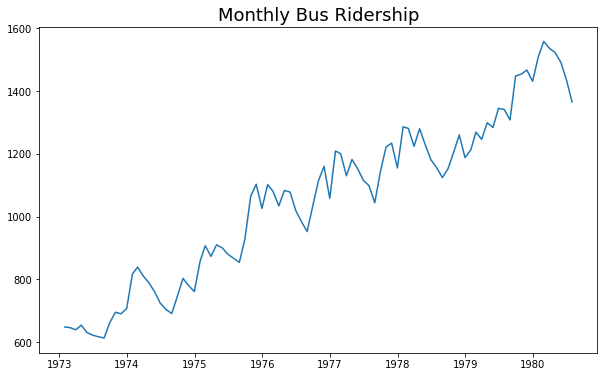

In [35]:
# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train['bus_ridership'])
plt.title(label = 'Monthly Bus Ridership', fontsize=18)
plt.show();

<details><summary>By looking at this data, is there is strong evidence of seasonality? If so, what evidence supports seasonality?</summary>

- Yes! There are repeated spikes that seem to occur every year or so.
- If we look back on our differenced ACF plot, we note a cyclical pattern as well.
</details>

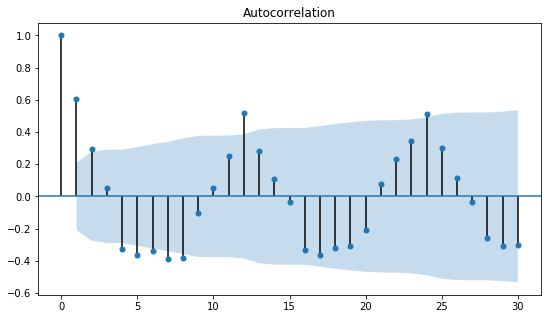

In [36]:
# Set figure/axes.
fig, ax = plt.subplots(figsize=(9,5))

# Generate plot.
plot_acf(train["bus_ridership"].diff(4).dropna(), lags=30, ax=ax);

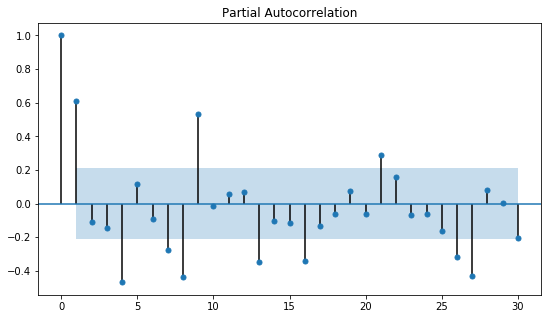

In [37]:
# Set figure/axes.
fig, ax = plt.subplots(figsize=(9,5))

# Generate plot.
plot_pacf(train["bus_ridership"].diff(4).dropna(), lags=30, ax=ax);

We can fit a **seasonal ARIMA (SARIMA) model** to our data. This model will:
- Have the ARIMA components we've described thus far, which are good for stationary trends.
- Include a seasonal component that will allow us to also account for seasonality that occurs over time.

The SARIMA model is given by $ARIMA(p, d, q) × (P, D, Q, S)$, where:
- $ARIMA(p, d, q)$ is the ARIMA model we've already discussed with AR order $p$, MA order $q$, and differencing order $d$.
- $(P, D, Q, S)$ refers to the seasonal AR order $P$, the seasonal MA order $Q$, the seasonal differencing order $D$, and the length of the season $S$.
- In order to **rigorously** fit a seasonal model, specify $S$ that appears to make sense.
    - Here, we might try 12.
        - In looking at the ACF plot, there's a clear seasonal trend that peaks every 12 months.
        - There are 12 months in a year, which makes even more sense that we'd see bus ridership fluctuate on a yearly pattern.
    - Then find the values of $P$, $D$, and $Q$ by looking at the ACF/PACF plot, but skipping by values of $S$. (i.e. if $S=12$, then check out the ACF and PACF plots 12 steps apart from one another.)
- In order to more realistically fit a seasonal model... GridSearch!

In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


384139544.03541803


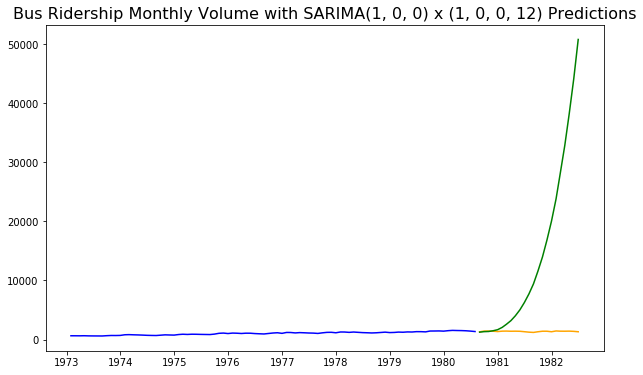

In [39]:
# Fit a SARIMA(1, 0, 0) x (1, 0, 0, 12) model.

sarima = SARIMAX(endog = train['bus_ridership'],
                 order = (1, 4, 0),              # (p, d, q)
                 seasonal_order = (1, 0, 0, 12)) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
# Start at time period 91 and end at 113.
preds = model.predict(start=91, end=113)

# Evaluate predictions.
print(mean_squared_error(test['bus_ridership'], preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train['bus_ridership'], color = 'blue')
plt.plot(test['bus_ridership'], color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Bus Ridership Monthly Volume with SARIMA(1, 0, 0) x (1, 0, 0, 12) Predictions', fontsize=16)
plt.show();

Our predictions are not matching the data!  Let's try tweaking parameters $P$, $D$, $Q$, and $S$ to see how we can get our green line to better match the orange line.

Generally, this is "most easily" done through a manual GridSearch process.

In [43]:
# Starting MSE and (P, D, Q).
mse = 99 * (10 ** 50)
final_P = 0
final_D = 0
final_Q = 0
final_S = 0

for P in range(3):
    for Q in range(3):
        for D in range(3):
            for S in range(0,13,4):
                try:
                    # Instantiate SARIMA model.
                    sarima = SARIMAX(endog = train['bus_ridership'],
                                     order = (1, 0, 0),              # (p, d, q)
                                     seasonal_order = (P, D, Q, S)) # (P, D, Q, S)

                    # Fit SARIMA model.
                    model = sarima.fit()

                    # Generate predictions based on training set.
                    # Start at time period 91 and end at 113.
                    preds = model.predict(start=91, end=113)

                    # Evaluate predictions.
                    print(f'The MSE for (1, 0, 0)x({P},{D},{Q},{S}) is: {mean_squared_error(train["bus_ridership"], preds)}')

                    # Save for final report.
                    if mse > mean_squared_error(train['bus_ridership'], preds):
                        mse = mean_squared_error(train['bus_ridership'], preds)
                        final_P = P
                        final_D = D
                        final_Q = Q
                        final_S = S

                except:
                    pass

print(f'Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x({final_P},{final_D},{final_Q},{final_S}).')
print(f'This model has an MSE of {mse}.')

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x(0,0,0,0).
This model has an MSE of 9900000000000000000000000000000000000000000000000000.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x(0,0,0,0).
This model has an MSE of 9900000000000000000000000000000000000000000000000000.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x(0,0,0,0).
This model has an MSE of 9900000000000000000000000000000000000000000000000000.


<details><summary>What should our main concerns be about a manual GridSearch process like this?</summary>

- The amount of time it takes to fit our models!
- We aren't cross-validating; we're only evaluating on all of our training data, which will likely end up overfitting. (Cross-validation is also more complicated with time series data; you can check out more [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) and [here](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/).)
</details>

# eXogenous Predictors

In time series analysis, we spend most of our time focused on how we can quantify the relationship between $Y_t$ and $Y_{t-k}$ and then use that relationship to forecast values of $Y_t$.

Future bus ridership probably isn't limited to just past performance of bus ridership. 

However, we can (and should!) still use $X$ variables in our data.
- In `statsmodels` and in various disciplines like econometrics, the $X$ variables are known as `exogenous`.
- More on exogenous/endogenous [here](http://www.statsmodels.org/stable/endog_exog.html).

In fact, the SARIMAX model stands for "Seasonal Autoregressive Integrated Moving Average with eXogenous regressors model."

#### One important practical note: 
If you're going to fit a SARIMAX model, make sure that your $X$ variable makes sense - especially timewise.
> For example, if we want to forecast bus ridership stock volume for December 2018 based on Intel's stock volume, I probably shouldn't use Intel's stock volume in December 2018 as an input. (I'm forecasting a value of $Y$ when I wouldn't have access to that value of $X$.)

I should probably lag my $X$ variable by at least one time point. 


| Index | $bus_t$ | $precip_{t-1}$ |
|-------|---------|--------------|
| 1     | $bus_1$ | NA           |
| 2     | $bus_2$ | $precip_1$     |
| 3     | $bus_3$ | $precip_2$     |
| 4     | $bus_4$ | $precip_3$     |


> `portland['precip_lag_1'] = portland['total_precip'].shift(1)`

In [48]:
train['precip_lag_1'] = train['total_precip'].shift(1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [49]:
# Starting MSE and (P, D, Q).
mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0
final_S = 0

for P in range(3):
    for Q in range(3):
        for D in range(3):
            for S in range(0,13,4):
                try:
                    # Instantiate SARIMA model.
                    sarima = SARIMAX(endog = train['bus_ridership'],
                                     order = (1, 0, 0),              # (p, d, q)
                                     seasonal_order = (P, D, Q, S),  # (P, D, Q, S)
                                     exog = train['precip_lag_1']) 

                    # Fit SARIMA model.
                    model = sarima.fit()

                    # Generate predictions based on training set.
                    # Start at time period 91 and end at 113.
                    preds = model.predict(start=91, end=113)

                    # Evaluate predictions.
                    print(f'The MSE for (1, 0, 0)x({P},{D},{Q},{S}) is: {mean_squared_error(train["bus_ridership"], preds)}')

                    # Save for final report.
                    if mse > mean_squared_error(train['bus_ridership'], preds):
                        mse = mean_squared_error(train['bus_ridership'], preds)
                        final_P = P
                        final_D = D
                        final_Q = Q
                        final_S = S

                except:
                    pass

print(f'Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x({final_P},{final_D},{final_Q},{final_S}).')
print(f'This model has an MSE of {mse}.')

Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x(0,0,0,0).
This model has an MSE of 990000000000000000.
